In [1]:
import bayes3d as b
import genjax
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt
import jax.tree_util as jtu
from tqdm import tqdm
import bayes3d.genjax
console = genjax.pretty(show_locals=False)
from genjax._src.core.transforms.incremental import NoChange
from genjax._src.core.transforms.incremental import UnknownChange
from genjax._src.core.transforms.incremental import Diff
import inspect

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/


In [3]:
b.RENDERER = None
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=100.0, fy=100.0,
    cx=50.0, cy=50.0,
    near=0.01, far=50.0
)

b.setup_renderer(intrinsics)

b.RENDERER.add_mesh_from_file("table.obj")
b.RENDERER.add_mesh_from_file("box_large.obj")
b.RENDERER.add_mesh_from_file("orange.obj")

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [4]:
importance_jit = jax.jit(b.genjax.model.importance)
del importance_jit
importance_jit = jax.jit(b.genjax.model.importance)

In [5]:
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 2.6, 2.3]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 1.0, 0.0]),
    )
)
all_box_dims = b.RENDERER.model_box_dims
key = jax.random.PRNGKey(13)
OUTLIER_VOLUME = 1000.0


In [50]:
key, (_,gt_trace) = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "parent_2": 0,
    "id_0": jnp.int32(0),
    "id_1": jnp.int32(1),
    "id_2": jnp.int32(1),
    "camera_pose": jnp.eye(4),
    "root_pose_0": table_pose,
    "face_parent_1": 0,
    "face_parent_2": 0,
    "face_child_1": 1,
    "face_child_2": 1,
    "variance": 0.001,
    "outlier_prob": 0.001,
}), (
    jnp.arange(3),
    jnp.arange(3),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-2.5, -2.5, -2*jnp.pi]), jnp.array([2.5, 2.5, 2*jnp.pi])]),
    b.RENDERER.model_box_dims, OUTLIER_VOLUME)
)
print(b.genjax.get_indices(gt_trace))
print(gt_trace.get_score())
b.genjax.viz_trace_meshcat(gt_trace)

[0 1 1]
-2717.6802


In [51]:
gt_trace.project(genjax.select("image"))

Array(-2668.1992, dtype=float32)

In [52]:
trace = gt_trace
N = b.genjax.get_indices(trace).shape[0] + 1
choices = trace.get_choices()
choices[f"parent_{N-1}"] = 0
choices[f"id_{N-1}"] = 2
choices[f"face_parent_{N-1}"] = 0
choices[f"face_child_{N-1}"] = 1
choices[f"contact_params_{N-1}"] = jnp.zeros(3)
trace = importance_jit(key, choices,
    (jnp.arange(N), *trace.get_args()[1:])
)[1][1]
b.genjax.viz_trace_meshcat(trace)
print(trace.project(genjax.select("image")))

-2703.5786


In [10]:
enum, enum_score, enum_parallel, enum_score_parallel  = b.genjax.make_enumerator([f"contact_params_3"])

In [53]:
bounds = 1.5
grid = b.make_translation_grid_enumeration_3d(
    -bounds, -bounds, -0.0,
    bounds, bounds, 0.0,
    50,50,1
)

In [54]:
scores = enum_score_parallel(trace, key, grid)

In [58]:
valid_indices = jnp.where(jnp.abs(scores - scores.max()) < 0.001)

In [59]:
traces = enum_parallel(trace, key, grid[valid_indices])

In [60]:
poses = b.genjax.get_poses(traces)[:,3,:,:][:,None,...]

In [61]:
poses.shape

(208, 1, 4, 4)

In [62]:
img = b.RENDERER.render_many(poses, jnp.array([2 for _ in range(len(valid_indices))]))

In [63]:
jnp.any(img[:,:,:,2] < 50.0)

Array(True, dtype=bool)

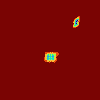

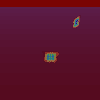

In [66]:
posterior_viz = b.get_depth_image(img.mean(0)[:,:,2])
b.overlay_image(b.get_depth_image(trace["image"][:,:,2]), posterior_viz)